In [530]:
MODEL_DIR = "../../../models/lstm_poc.h5"

In [531]:
import numpy as np

import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

import pandas as pd

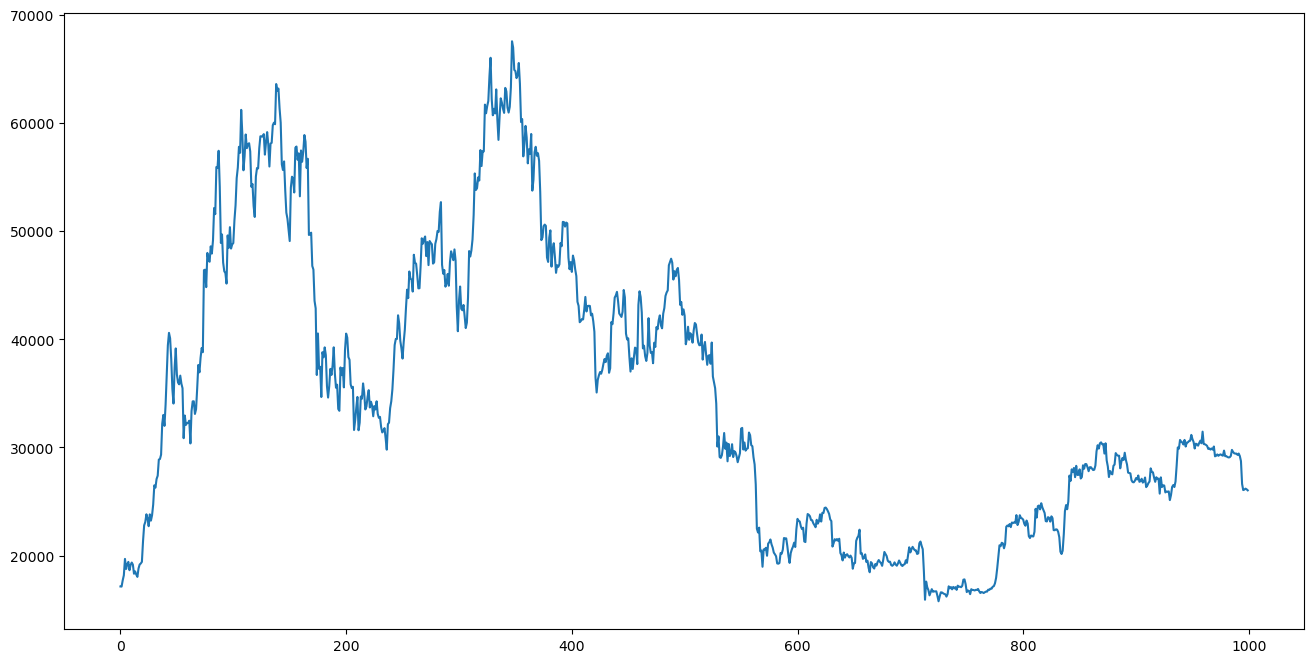

In [532]:
import ccxt
binance = ccxt.binance()
symbol = 'BTC/USDT'

ohlcv = binance.fetch_ohlcv(symbol, '1d', limit=1000)
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')


plt.figure(figsize=(16,8))
plt.plot(df["close"],label='close Price history')

In [533]:
def ROC(cp, tf):
    roc = []
    x = tf
    while x < len(cp):
        rocs = (cp[x] - cp[x-tf]) / cp[x-tf]
        roc.append(rocs)
        x += 1
        
    return roc

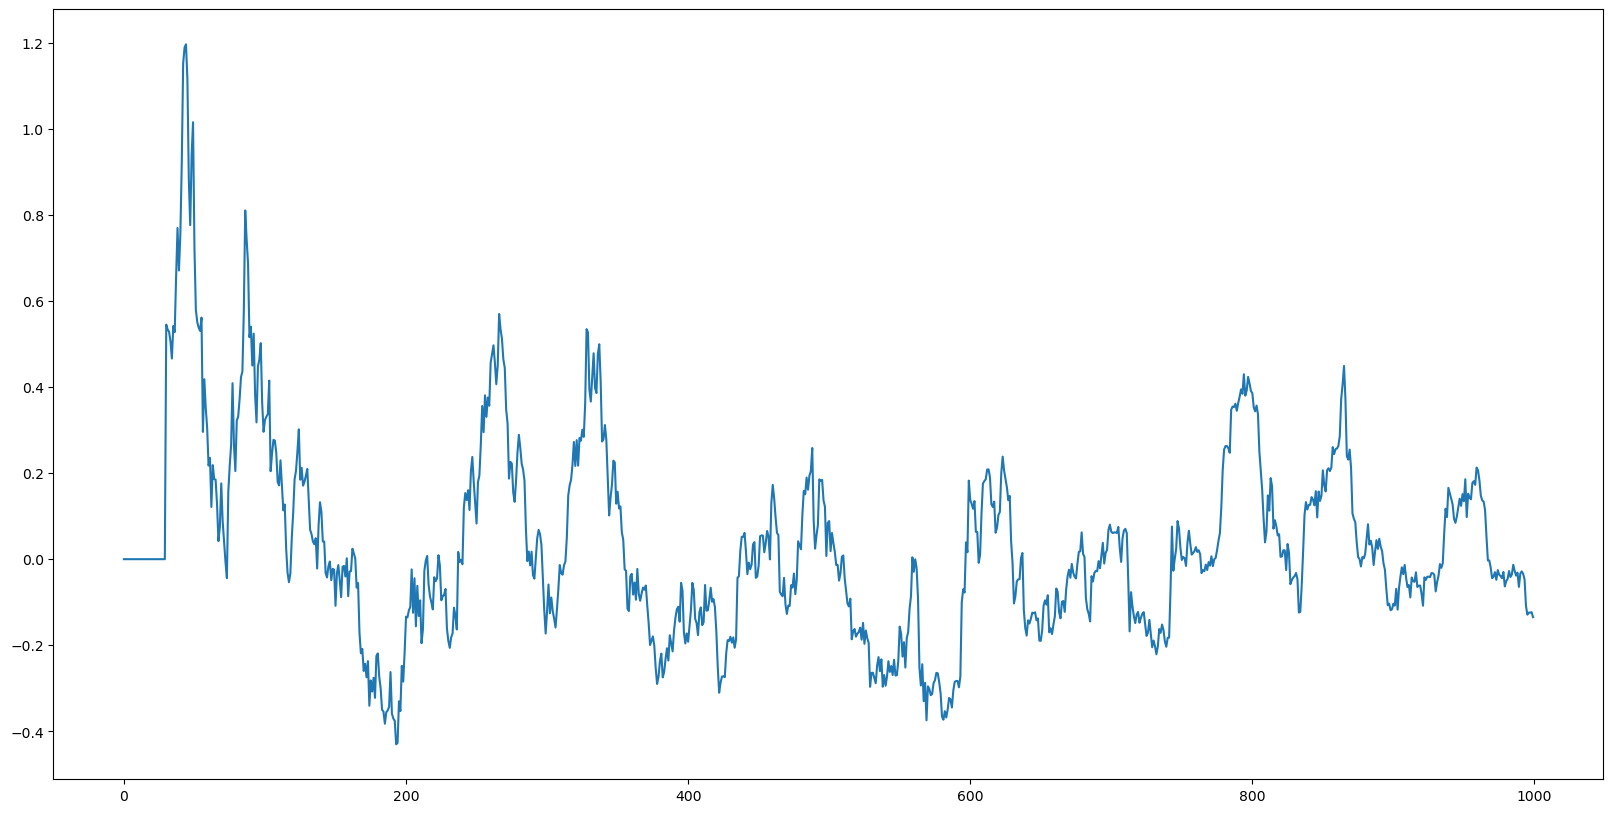

In [534]:
roc = ROC(df['close'], 30)
roc = np.concatenate((np.zeros(30), roc))

plt.plot(roc,label='close Price history')
df['close'] = roc

In [535]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

In [536]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['timestamp','close'])

for i in range(0,len(data)):
    new_dataset["timestamp"][i]=data['timestamp'][i]
    new_dataset["close"][i]=data["close"][i]

new_dataset.index=new_dataset.timestamp
new_dataset.drop("timestamp",axis=1,inplace=True)

In [537]:
final_dataset=new_dataset.values

train_data=final_dataset[0:-100,:]
valid_data=final_dataset[-100:,:]

scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [538]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

840/840 - 15s - loss: 0.0049


In [539]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

In [540]:
lstm_model.save(MODEL_DIR)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20532\835861264.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


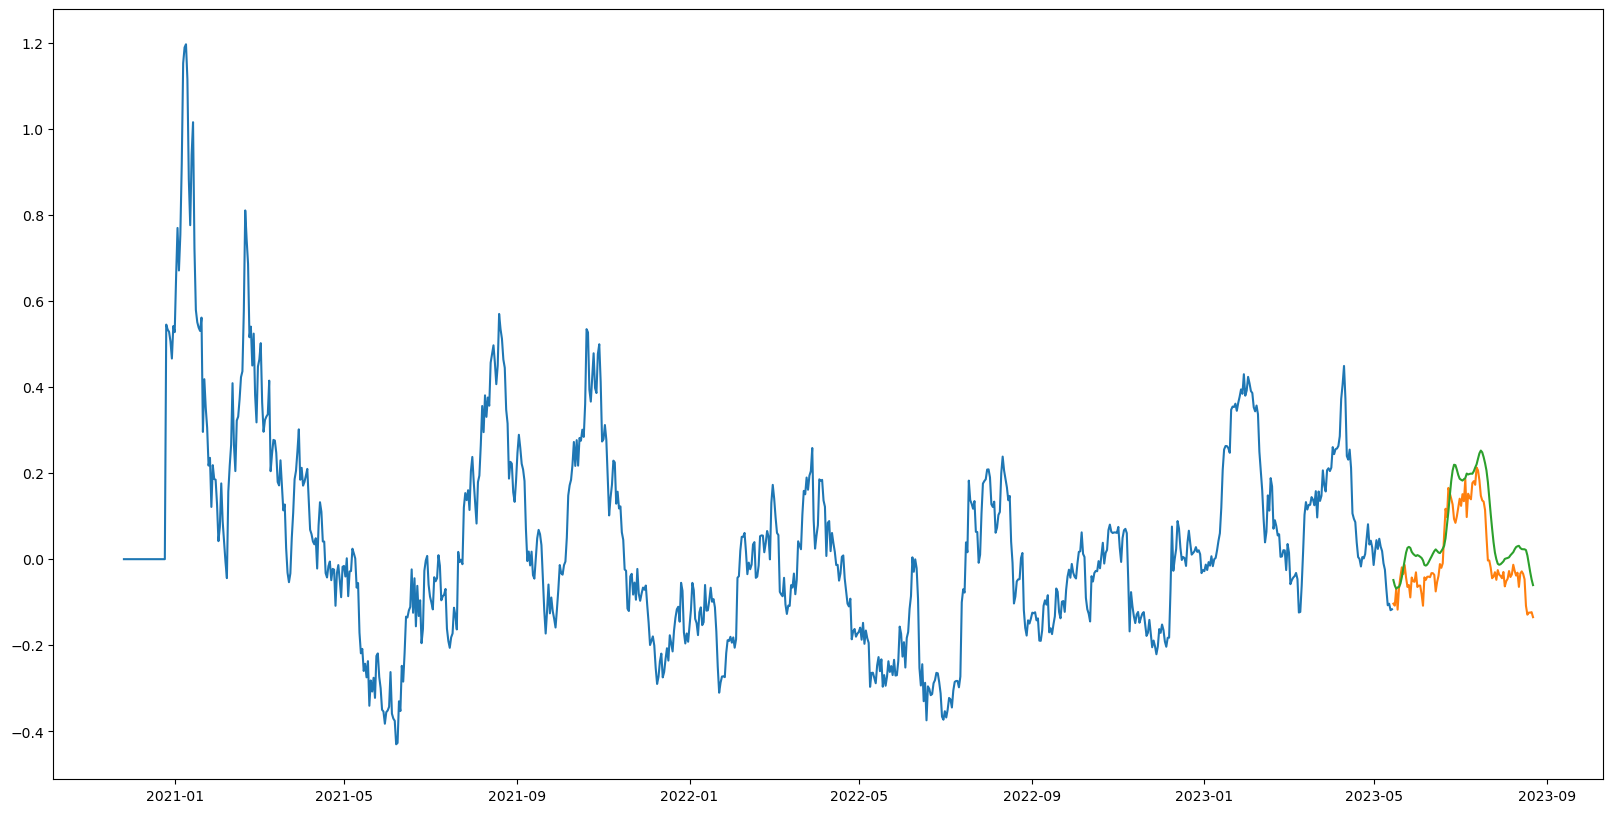

In [541]:
train_data=new_dataset[:-100]
valid_data=new_dataset[-100:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["close"])
plt.plot(valid_data[['close',"Predictions"]])